# 中文评论分类

组员：
* 赵翔宇 11611309
* 徐源诚 11611010

## 要求

In this project you are given Chinese comments data, what you should do is to **find good classifiers that give the most accuarate ranking for each comment**（goal）.
给定中文评论数据，要求找到合适的分类器进行打分星级分类



You have to do the following task: data exploration (e.g., data visualization), data preprocessing, try different models and make comparisons, parameter tuning, model assessment and improvement, conclusion. Please compare the results with your intuition. 

## 1 数据预处理

### 1.1 数据集描述&标签转化

读入数据集并查看基本信息，打印前5行

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv', encoding='gb18030')

data.head()

,comment,star
0,口味：不知道是我口高了，还是这家真不怎么样。 我感觉口味确实很一般很一般。上菜相当快，我敢说...,2
1,菜品丰富质量好，服务也不错！很喜欢！,4
2,说真的，不晓得有人排队的理由，香精香精香精香精，拜拜！,2
3,菜量实惠，上菜还算比较快，疙瘩汤喝出了秋日的暖意，烧茄子吃出了大阪烧的味道，想吃土豆片也是口...,5
4,先说我算是娜娜家风荷园开业就一直在这里吃 每次出去回来总想吃一回 有时觉得外面的西式简餐总是...,4


统计行列数，列名，以及各个分数的样本数

In [ ]:
#此处处理统计信息的代码


这份餐厅食客评论信息数据集，包含$comment$、$star$2个属性，总计2000个样本，其中得分为1、2、4、5的类内各500个样本。

发现没有3分的评论（i.e.没有“中间评价”），这说明数据集“好评”与“差评”的“间隔相对较大，而用户的评论会有很大主观性，4分与5分、1分与2分的边界很模糊。综上考虑，一个合理的处理是将打分大于3的评论映射到“好评集”（标签为1），余下的映射到“差评集”（标签为0），这样就把**多分类问题转化为更易处理的二分类问题**。

In [ ]:
#转化成正负情感，加入一列名为“sentiment”表示好评或差评，提示：使用lambda函数

# 打印前5行
data.head()

### 1.2 分词

我们要将$comment$列的文本信息，处理成可以用于模型训练的数值矩阵。首先，我们导入中文分词库$jieba$对评论文本进行分词。

In [4]:
import jieba

In [5]:
def chinese_word_cut(mytext):
    return " ".join(jieba.cut(mytext))

In [6]:
data['cutted_comment'] = data.comment.apply(chinese_word_cut)
data_cutted=pd.DataFrame({"comment":data["cutted_comment"],"sentiment":data["sentiment"],"star":data["star"]})
data_cutted.head()


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\徐源诚\AppData\Local\Temp\jieba.cache
Loading model cost 1.000 seconds.
Prefix dict has been built succesfully.


,comment,sentiment,star
0,口味 ： 不 知道 是 我口 高 了 ， 还是 这家 真 不怎么样 。 我 感觉 口味 ...,0,2
1,菜品 丰富 质量 好 ， 服务 也 不错 ！ 很 喜欢 ！,1,4
2,说真的 ， 不 晓得 有人 排队 的 理由 ， 香精 香精 香精 香精 ， 拜拜 ！,0,2
3,菜量 实惠 ， 上菜 还 算 比较 快 ， 疙瘩汤 喝出 了 秋日 的 暖意 ， 烧茄子 吃...,1,5
4,先说 我 算是 娜娜 家风 荷园 开业 就 一直 在 这里 吃 每次 出去 回来 总想 ...,1,4


### 1.3 文本可视化

直觉告诉我们，那些在整个数据集组成的语料库中出现频率较高的词汇，很大概率对评论的情感倾向有着更大的贡献，为了更直观清楚地看到这一点，我们使用$wordcloud$库进行文本可视化。
需要命令行模式下安装wordcloud:

pip install wordcloud

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

针对好评跟差评的文本，建立$wordcloud$对象$wc$，绘制词云。

负面评价的词云是


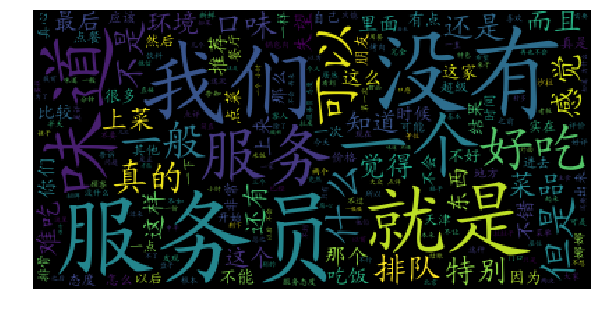

正面评价的词云是


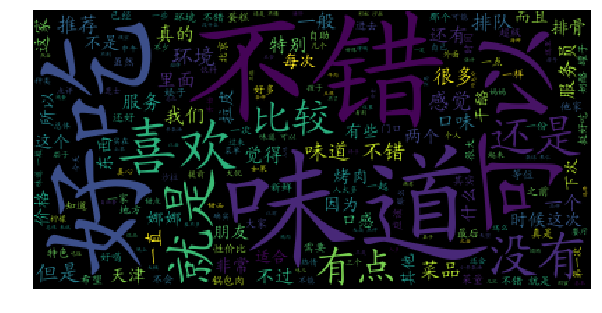

In [8]:
wc=WordCloud(font_path="Kaiti.ttf")
for i in {1,0}:
    if i==0:
        print("负面评价的词云是")
    else:
        print("正面评价的词云是")
    wc.generate("".join(data_cutted["comment"][data_cutted["sentiment"]==i]))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(wc)
    plt.show()


### 1.4 引入停用词表

从词云展示的词频统计图看，“好吃”、“不错”等词语可以表现出评论的正向情感，有助于区分类;然而也存在诸如“没有”、“就是”等没有意义且出现频率很高的词，这些词模糊了“好”与“坏”的边界，因此我们需要导入停用词文件$stopwordsHIT.txt$，将它们筛选出来。

我们采用了哈工大创建共享的停用词表，下面输出了停用词表的后10行。

In [9]:
#加入停用词
#通过方法将Txt转化成list
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file) as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

stop_words_file = "stopwordsHIT.txt"
stopwords = get_custom_stopwords(stop_words_file)
stopwords[-10:] 

['呃', '呗', '咚', '咦', '喏', '啐', '喔唷', '嗬', '嗯', '嗳']

## 2 向量化与模型

### 2.1 向量化方法

下面我们要对经过分词后的文本进行向量化，以满足输入模型的条件。

常见的文本特征信息提取的方法有0/1模型、TF模型、TF-IDF模型，这里我们简短说明三者的基本原理：

a.**one-hot表示法**先将文本数据集中不重复的单词提取出来，得到一个大小为N的词汇表。然后用一个N维的向量来表示一个文本样本，向量中的第d个维度上的1表示词汇表中的第d个单词出现在这个样本中，0表示未出现。 

b.**tf (term-frequency)** 表示法除了考虑单词是否出现外，还关心单词出现的次数，因此tf矩阵中每个元素表示其对应的单词在文章中出现的次数/文章中的总次数，即单词在文章中的频率。 

c.**tf-idf (term frequency–inverse document frequency)** ，不仅考虑了单词在文章中的出现次数，还考虑了其在整个文本数据集中的出现次数。其主要思想是：如果某个词或短语在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力。

在实际操作中，我们创建了$Vector$类，并设定参数$modle$以选择不同的向量化方法。其中“CountVectorizer_Normal”全部采用默认值作为参照，"CountVectorizer_Improve"和"tf-idf"我们分别使用0/1模型与TF-IDF模型。此外，我们设定了$max\_df$、$min\_df$参数，将评论集中过于平凡或者太过特殊的特征词去除、用正则表达式去除数字，并导入停用词。

In [10]:
max_df = 0.8 # 在超过这一比例的文档中出现的关键词（过于平凡），去除掉。
min_df = 3 # 在低于这一数量的文档中出现的关键词（过于独特），去除掉。
class Vector:
    def __init__(self,method):
        self.method=method
        if method=="CountVectorizer_Normal":#最差
            from sklearn.feature_extraction.text import CountVectorizer
            self.vect=CountVectorizer()
            
        elif method=="CountVectorizer_Improve":
            from sklearn.feature_extraction.text import CountVectorizer
            self.vect = CountVectorizer(max_df = max_df,
                       min_df = min_df,
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',
                       stop_words=frozenset(stopwords))
            #去除掉所有的数字
        elif method=="tf-idf":
            from sklearn.feature_extraction.text import TfidfVectorizer
            self.vect=TfidfVectorizer(max_df,min_df,token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b'
                                      ,stop_words=frozenset(stopwords)
                                      )
                        
    def fit(self,X):
        self.vectorizer = self.vect.fit(X)
        return self.vectorizer.transform(X).toarray()   

### 2.2 模型的选择

Python的机器学习工具包scikit-learn 为我们提供了模型选择的“cheat sheet”，我们可以对照下图结合数据集真实情况对模型进行选择。

<img style="float: middle;"  src="choosemodel.png"  width="85%">

从$START$起始，我们要做的是带标签的文本数据量不超100K的二分类问题，因此选择朴素贝叶斯（Native Bayes）可能会得到最佳的分类效果。为了验证这一点，我们同时也选择了SVM、Adaboost、Randomforest模型进行对照。

In [11]:
#把train_x,test_x向量化
class Classifier:
    def __init__(self,method):
        self.method=method     
        if method=="SVM":
            from sklearn.svm import SVC
            self.model=SVC()
        elif method=="Adaboost":
            from sklearn.ensemble import AdaBoostClassifier
            self.model=AdaBoostClassifier()
        elif method=="RandomForest":
            from  sklearn.ensemble import RandomForestClassifier
            self.model=RandomForestClassifier()
        elif method=="Nbayes":
            from sklearn.naive_bayes import MultinomialNB
            self.model=MultinomialNB(alpha=1.0,fit_prior=True)
    def fit(self,train_X,train_y):
        self.train_X=train_X
        self.train_y=train_y
        self.model.fit(self.train_X,self.train_y)
    def predict(self,test_X):
        self.test_X=test_X
        return self.model.predict(self.test_X)
    

大家还可以增加逻辑回归尝试一下效果，在以上类初始化函数中加入LogisticRegression方法。应该是与朴素贝叶斯效果相当。其他方法如KNeighborClassifier和DecisionTreeClassifier效果较差。

## 3 模型评价及改进

### 3.1 选择表现最好的模型

首先，我们创建了储存有向量化方法与模型名称的列表$vectors$、$models$,接着创建实例$vec$、$clf$循环选用不同参数，训练模型。我们将数据集划分为训练集、测试集，并输出$accuracy\_score$以对比不同模型的效果。

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

vectors=["CountVectorizer_Normal","CountVectorizer_Improve","tf-idf"]
models=["SVM","Adaboost","RandomForest","Nbayes"]

for vec_item in vectors:
    for model_item in models:
        #不同向量化方法
        vect=Vector(vec_item)
        data=pd.DataFrame(vect.fit(data_cutted["comment"]),columns=vect.vect.get_feature_names())
        #划分数据集
        train_X,test_X,train_y,test_y=train_test_split(data,data_cutted["sentiment"],random_state=2)
        #不同模型
        clf=Classifier(model_item)
        clf.fit(train_X,train_y)
        predict=clf.predict(test_X)
        #评价
        validy=test_y
        print(vec_item,"+",model_item,"\n")
        print (metrics.classification_report(predict, validy))
        print(metrics.confusion_matrix(predict, validy))
        print("accuracy score:",metrics.accuracy_score(predict, validy))

CountVectorizer_Normal + SVM 

             precision    recall  f1-score   support

          0       0.07      0.95      0.13        19
          1       1.00      0.52      0.68       481

avg / total       0.96      0.53      0.66       500

[[ 18   1]
 [232 249]]
accuracy score: 0.534
CountVectorizer_Normal + Adaboost 

             precision    recall  f1-score   support

          0       0.72      0.83      0.77       216
          1       0.85      0.75      0.80       284

avg / total       0.79      0.78      0.79       500

[[179  37]
 [ 71 213]]
accuracy score: 0.784
CountVectorizer_Normal + RandomForest 

             precision    recall  f1-score   support

          0       0.82      0.79      0.81       258
          1       0.79      0.81      0.80       242

avg / total       0.80      0.80      0.80       500

[[205  53]
 [ 45 197]]
accuracy score: 0.804
CountVectorizer_Normal + Nbayes 

             precision    recall  f1-score   support

          0       0.78   

我们可以看到，TF-IDF+朴素贝叶斯具有最好的分类效果，这与我们的预期相一致。

### 3.2 调试超参数

接下来我们要调整向量化方法和模型的参数，以优化模型使其具有更佳的表现。

可是，如果每次修改一个参数，或者换用测试集，都重新运行上面的函数是很低效麻烦的，而且极容易在中间出现错误。Scikit-learn提供的管道(pipeline)功能可以方便解决这个问题。结合gridsearch，我们可以更迅速地完成调试参数工作。

创建管道实例$pipline\_obj$,相当于把$vect$、$clf$模型串联成一个整体，因而可以把训练、调用这些顺序工作连接起来，隐藏其中的功能顺序关联，从外部一次调用，就能完成顺序定义的全部工作。


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
#现在选择tf-idf+Nbayes
vect=Vector("tf-idf")
clf=Classifier("Nbayes")
pipeline_obj=Pipeline([("vect",vect.vect),("clf",clf.model)])
print(pipeline_obj.steps )  #输出新的pipline_obj模型的步骤

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding=3, input=0.8, lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'哩', '由此可见', '嘎登', '}', '［③ｂ］', '那里', '让', '［③ａ］', '［⑤ｅ］', '有的', '从而', '诸位', '［②⑧］', '怎么', '１２％', '［②ｈ］', '@', '替', '以致', '及', '彼此', 'ＺＸＦＩＴＬ', '［②⑦］', 'Lex ', '［①ｄ］', '果然', '其它', '可是', '［①Ａ］', '⑦', '即使', 'В', '而已', '不怕', '【', '故', '』', '旁人', '如若', '哪些', '之', '[', '［⑤ｄ］', '恰恰相反'...吧哒', '④', '比如', '［⑤］］', '此间', '哉', '此', '己', '只是', '至', '经过', '你', '０：２ ', '＝″', '虽说', '一方面', '＜φ'}),
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b[^\\d\\W]\\w+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]


C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


补充1：优化前的4分类问题

In [14]:
#划分分词后的raw data
train_X,test_X,train_y,test_y=train_test_split(data_cutted.comment,data_cutted.sentiment,random_state=2)

In [15]:
#定义需要遍历的所有候选参数的字典，key_name需要用__分隔模型名和模型内部的参数名'''
#括号内是离散的
parameters = {
    'vect__max_df': (0.6,0.7,0.65),'vect__min_df':(0.0001,0.001),
    'vect__use_idf': (True, False),'vect__norm': ('l1', 'l2'),
    'clf__alpha': (1,1.5,2),}
grid_search=GridSearchCV(pipeline_obj,parameters,n_jobs=1,verbose=1)
grid_search.fit(train_X,train_y)
best_params=dict(grid_search.best_estimator_.get_params())
print(best_params)         #输出模型表现最佳的最优参数组合

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'memory': None, 'steps': [('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding=3, input=0.8, lowercase=True,
        max_df=0.6, max_features=None, min_df=0.0001, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'哩', '由此可见', '嘎登', '}', '［③ｂ］', '那里', '让', '［③ａ］', '［⑤ｅ］', '有的', '从而', '诸位', '［②⑧］', '怎么', '１２％', '@', '［②ｈ］', '替', '以致', '及', '彼此', 'ＺＸＦＩＴＬ', '［②⑦］', 'Lex ', '［①ｄ］', '果然', '其它', '可是', '［①Ａ］', '⑦', '即使', 'В', '而已', '不怕', '【', '故', '』', '旁人', '如若', '哪些', '之', '[', '［⑤ｄ］', '恰恰相反'...吧哒', '④', '比如', '［⑤］］', '此间', '哉', '此', '己', '只是', '至', '经过', '你', '０：２ ', '＝″', '虽说', '一方面', '＜φ'}),
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b[^\\d\\W]\\w+\\b', tokenizer=None,
        use_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=1.5, class_prior=None, fit_prior

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   12.9s finished


将上面得到的最优参数重新输入$pipeline\_obj$模型，再次评价，并输出混淆矩阵，可以看到结果得到了优化。

In [16]:
pipeline_obj.set_params(vect__max_df=0.8,vect__min_df=0.001,vect__use_idf=True,vect__norm="l2",clf__alpha=1.5)
pipeline_obj.fit(train_X,train_y)
#print(test_X) 是中文
predict=pipeline_obj.predict(test_X)
#print(test_X) 仍是中文
# 评价模型
validy=test_y
print (metrics.classification_report(predict, validy))
print(metrics.confusion_matrix(predict, validy))
print(metrics.accuracy_score(predict, validy))

             precision    recall  f1-score   support

          0       0.77      0.88      0.82       219
          1       0.90      0.80      0.84       281

avg / total       0.84      0.83      0.83       500

[[193  26]
 [ 57 224]]
0.834


## 4 讨论：情感分析评价的多分类问题

以上我们做的是根据中文评论的情感倾向进行二分类，而实际上由于用户自身打分的主观性，我们很难找到评论与得分精确的对应关系。下面是我们用训练好的模型对评论数据集进行多分类，并输出star评分：

In [20]:
#重新选取数据集，即选取star
train_X,test_X,train_y,test_y=train_test_split(data_cutted.comment,data_cutted.star,random_state=2)
#带入pipeline
pipeline_obj.fit(train_X,train_y)
predict=pipeline_obj.predict(test_X)

# 评价模型
validy=test_y
from sklearn import metrics
print (metrics.classification_report(predict, validy))
print(metrics.confusion_matrix(predict, validy))
print(metrics.accuracy_score(predict, validy))

             precision    recall  f1-score   support

          1       0.53      0.63      0.58       109
          2       0.45      0.48      0.47       115
          4       0.43      0.50      0.46       113
          5       0.64      0.47      0.54       163

avg / total       0.53      0.51      0.51       500

[[69 32  6  2]
 [35 55 14 11]
 [10 17 56 30]
 [15 17 55 76]]
0.512


可以看到，一分一类情形下的模型区分效果并不好，且识别率很难提高。